# Santander Customer Transaction Prediction - Kaggle
This code contains basic EDA and some submissions for the Santander Customer Transaction Prediction contest hosted on Kaggle. https://www.kaggle.com/c/santander-customer-transaction-prediction

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from numba import jit
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
def load_dataset():
    train_initial = pd.read_csv('train.csv')
    test_initial = pd.read_csv('test.csv')
    return train_initial, test_initial

def preprocess(train):
    train = train.drop(['ID_code'], axis=1)

    train_X = train.drop(['target'], axis=1).values
    train_y = train[['target']].values
    
    return train_X, train_y

def preprocess_test(test):
    test = test.drop(['ID_code'], axis=1)
    
    return test

In [4]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

initial train data size (with label) (200000, 202)


## Basic EDA
We begin by checking null values in the dataset and looking at summary statistics for various features. Then, we fit a Random Forest classifier and plot feature importance graph.

In [7]:
# check if any values are null
print(train.isna().values.any())
print(train.isnull().values.any())

print(test.isna().values.any())
print(test.isnull().values.any())

train.describe()

False
False
False
False


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [24]:
train_X, train_y = preprocess(train)
print("train data size (without label)", train_X.shape)

rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(train_X, train_y)

train data size (without label) (200000, 200)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

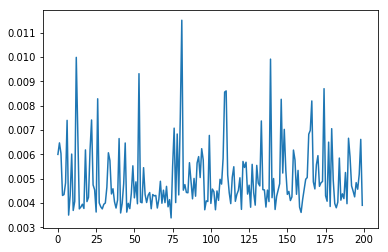

In [25]:
plt.plot(rf.feature_importances_)

## Modeling
We first start by running Logistic Regression and Gaussian Naive Bayes models.

In [19]:
estimators_logReg = [('scale', MinMaxScaler()), ('LogReg', LogisticRegression(C=1))]
pipeline = Pipeline(estimators_logReg)

param_values = [1e-01, 1e-00, 1e+01, 1e+02, 1e+03, 1e+04, 1e+05, 1e+06, 1e+07, 1e+08]
param_grid = dict(LogReg__C=param_values)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, 
                           return_train_score=True, n_jobs=-1)

grid_search.fit(train_X, train_y)

print("Regularization param values: " + str(param_values))
print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))
print("Best test score: " + str(max(grid_search.cv_results_['mean_test_score'])))

Regularization param values: [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Mean train scores: [0.86128572 0.8616372  0.86167784 0.86167968 0.86167992 0.86167993
 0.86167994 0.86167994 0.86167994 0.86167994]
Mean test scores: [0.85898216 0.85930158 0.8593374  0.85933974 0.85933998 0.85934008
 0.85934011 0.85934011 0.85934011 0.85934011]
Best test score: 0.8593401096314364


In [27]:
estimators_gnb = [('scale', MinMaxScaler()), ('GNB', GaussianNB(priors=None, var_smoothing=1e-09))]
pipeline_gnb = Pipeline(estimators_gnb)
pipeline_gnb.fit(train_X, train_y)

test_X = preprocess_test(test)
test_y = pipeline_gnb.predict_proba(test_X)

out = test[['ID_code']].copy()
out['target'] = test_y[:,1]
out.to_csv("sub1.csv", sep=",", index=False)

### Gradient Boosted Decision Trees
Next, we move to running Gradient Boosting Decision Trees from lightGBM. The code posted here is due to this Kaggle kernel: https://www.kaggle.com/gpreda/santander-fast-compact-solution The previous models using Logistic Regression and Gaussian Naive Bayes gave AUC scores around 0.86 and 0.88 on public Leaderboard. With the following code run for 15 CV folds, AUC jumps to 0.9

In [29]:
train, test = load_dataset()
print("reloaded train data size (with label)", train.shape)

reloaded train data size (with label) (200000, 202)


In [35]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']
param = {
    'bagging_freq': 5,  'bagging_fraction': 0.331,  'boost_from_average':'false',   
    'boost': 'gbdt',    'feature_fraction': 0.0405, 'learning_rate': 0.0083,
    'max_depth': -1,    'metric':'auc',             'min_data_in_leaf': 80,     
    'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,  'num_threads': 8,            
    'tree_learner': 'serial',   'objective': 'binary',       'verbosity': 1
}
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv("sub2.csv", index=False)

Fold 0
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.932874	valid_1's auc: 0.898027
[10000]	training's auc: 0.95112	valid_1's auc: 0.899403
Early stopping, best iteration is:
[9400]	training's auc: 0.94919	valid_1's auc: 0.899495
Fold 1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.930821	valid_1's auc: 0.903211
[10000]	training's auc: 0.949484	valid_1's auc: 0.904552
Early stopping, best iteration is:
[9512]	training's auc: 0.947896	valid_1's auc: 0.904609
Fold 2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.934079	valid_1's auc: 0.893663
[10000]	training's auc: 0.951942	valid_1's auc: 0.89551
Early stopping, best iteration is:
[9604]	training's auc: 0.950714	valid_1's auc: 0.895558
CV score: 0.89984 


### Data Augmentation
Here, we move to trying data augmentation technique on this dataset. This technique creates additional training examples by sampling features from both classes. The positive class is upsampled by a ratio of 1:2. After augmentation, gradient boosted decision trees are run. The code posted here is due to this Kaggle kernel: https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment This model run with 15 fold CV results in an AUC of 0.901 on the public LB.

In [36]:
random_state = 42
np.random.seed(random_state)

@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y
    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
oof = train[['ID_code', 'target']]
oof['predict'] = 0
predictions = test[['ID_code']]
val_aucs = []

features = [col for col in train.columns if col not in ['target', 'ID_code']]
X_test = test[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    X_train, y_train = train.iloc[trn_idx][features], train.iloc[trn_idx]['target']
    X_valid, y_valid = train.iloc[val_idx][features], train.iloc[val_idx]['target']
    
    N = 1
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=1000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("sub3.csv", index=False)

Training until validation scores don't improve for 1000 rounds.
[5000]	training's auc: 0.919413	valid_1's auc: 0.898107
[10000]	training's auc: 0.933304	valid_1's auc: 0.899452
Early stopping, best iteration is:
[9028]	training's auc: 0.930922	valid_1's auc: 0.899545
Training until validation scores don't improve for 1000 rounds.
[5000]	training's auc: 0.917725	valid_1's auc: 0.903018
[10000]	training's auc: 0.93193	valid_1's auc: 0.904785
Early stopping, best iteration is:
[9211]	training's auc: 0.929964	valid_1's auc: 0.904857
Training until validation scores don't improve for 1000 rounds.
[5000]	training's auc: 0.920496	valid_1's auc: 0.893728
[10000]	training's auc: 0.934519	valid_1's auc: 0.896066
Early stopping, best iteration is:
[9066]	training's auc: 0.932204	valid_1's auc: 0.896143
Mean auc: 0.900181607, std: 0.003586000. All auc: 0.900148681.
